In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 
from fastai.callbacks import *
import pandas as pd
from tqdm import tnrange, tqdm_notebook

In [3]:
# See how many devices are around
print('Devices available: ', torch.cuda.device_count())
# Set it to a particular device
CUDA_DEVICE = 4
print('Set device: ', CUDA_DEVICE)
torch.cuda.set_device(CUDA_DEVICE)
# Check which device you are on
print('Current device: ', torch.cuda.current_device())

Devices available:  8
Set device:  4
Current device:  4


In [4]:
DATA_PATH = '../../data/virtual-operator'
TRAIN_DATASET = os.path.join(DATA_PATH, 'train.csv')
VAL_DATASET = os.path.join(DATA_PATH, 'val.csv')
TEST_DATASET  = os.path.join(DATA_PATH, 'test.csv')

In [5]:
LM_PATH=Path('../../models/ulmfit/lm/virtual-operator')
LM_PATH.mkdir(exist_ok=True)

In [6]:
def read_data(filename):
    data = pd.read_csv(filename, sep=";", names =['utterance','label'], header=None, dtype={'utterance':str, 'label': str} )
    return data

In [7]:
train_dataset = read_data(TRAIN_DATASET).dropna()
val_dataset = read_data(VAL_DATASET).dropna()
test_dataset = read_data(TEST_DATASET).dropna()

In [8]:
tokenizer = Tokenizer(lang='pt', n_cpus=10)

In [9]:
data_lm = TextLMDataBunch.from_df(LM_PATH, train_df = train_dataset, valid_df = val_dataset,  bs=128, text_cols=0)

In [10]:
data_lm.save('data_lm_virtual_operator')

In [11]:
data_lm = load_data(LM_PATH, 'data_lm_virtual_operator', bs=64)

In [12]:
weights_pretrained = 'wiki_pt_lm_30k_step4'
itos_pretrained = 'wiki_pt_lm_30k_itos_vocab'
pretained_data = (weights_pretrained, itos_pretrained)

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretained_data, pretrained=False, drop_mult=0, callback_fns=ShowGraph)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02


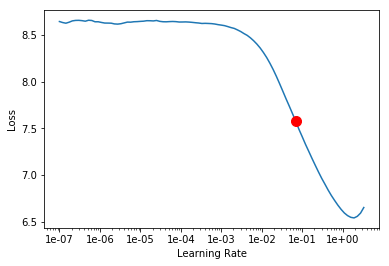

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,3.140265,3.114724,0.366938,01:46
1,3.102388,3.088475,0.371138,01:45
2,3.024431,3.035418,0.376833,01:45
3,2.911459,2.980243,0.383196,01:45
4,2.832967,2.966908,0.385350,01:45


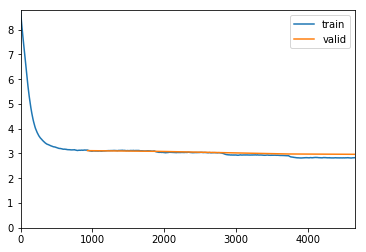

Better model found at epoch 0 with val_loss value: 3.1147239208221436.
Better model found at epoch 1 with val_loss value: 3.088475227355957.
Better model found at epoch 2 with val_loss value: 3.0354177951812744.
Better model found at epoch 3 with val_loss value: 2.9802427291870117.
Better model found at epoch 4 with val_loss value: 2.9669079780578613.


In [15]:
learn.fit_one_cycle(5, 3e-2, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wikipt-30k-FT-virtual-operator-head-best')])

In [ ]:
learn.purge()
learn.load('wikipt-30k-FT-virtual-operator-head-best') 

epoch,train_loss,valid_loss,accuracy,time
0,2.911391,2.949193,0.383257,02:08
1,2.882530,2.885931,0.393080,02:08
2,2.803784,2.840865,0.400626,02:09
3,2.629409,2.834233,0.402926,02:09
4,2.439624,2.895283,0.398791,02:09


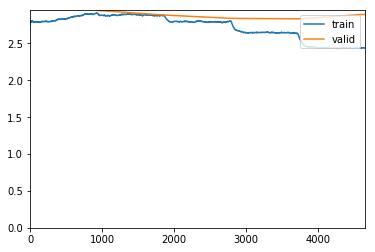

Better model found at epoch 0 with val_loss value: 2.949193239212036.
Better model found at epoch 1 with val_loss value: 2.8859314918518066.
Better model found at epoch 2 with val_loss value: 2.840864658355713.
Better model found at epoch 3 with val_loss value: 2.834233045578003.


In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, 8E-3, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wikipt-30k-FT-virtual-operator-step2-best')])

In [21]:
np.exp(2.834966)

17.02982127662944

In [ ]:
learn.purge()
learn.load('wikipt-30k-FT-virtual-operator-step2-best')

In [31]:
learn.save_encoder('wikipt-30k-FT-virtual-operator-encoder')

In [40]:
!cp ../../models/ulmfit/lm/virtual-operator/models/wikipt-30k-FT-virtual-operator-encoder.pth models/

In [27]:
learn.predict('o meu controle ', 3)

'o meu controle  remoto está com'

In [10]:
data_class = TextClasDataBunch.from_df(path = "", train_df = train_dataset, valid_df = val_dataset, test_df = test_dataset,  vocab=data_lm.train_ds.vocab,tokenizer=tokenizer, bs=128, text_cols=['utterance'], label_cols=['label'])

In [33]:
del data_lm
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.1, callback_fns=ShowGraph)
learn.load_encoder('wikipt-30k-FT-virtual-operator-encoder')
learn.freeze()

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02


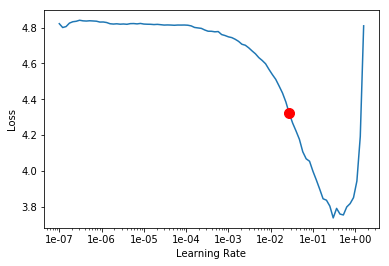

In [13]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,0.781452,0.754268,0.807669,01:32
1,0.953700,0.861115,0.787032,01:32
2,1.139098,1.018328,0.749548,01:28
3,0.916615,0.971817,0.759287,01:32
4,1.052087,0.878420,0.783133,01:30
5,0.846761,0.801635,0.796119,01:28
6,0.756987,0.751871,0.803415,01:32
7,0.825176,0.618428,0.836347,01:26
8,0.616925,0.532365,0.855714,01:26
9,0.498579,0.507079,0.863401,01:26


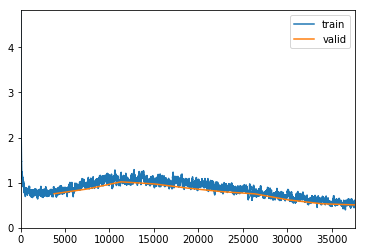

Better model found at epoch 0 with val_loss value: 0.754267692565918.
Better model found at epoch 6 with val_loss value: 0.7518711686134338.
Better model found at epoch 7 with val_loss value: 0.6184276938438416.
Better model found at epoch 8 with val_loss value: 0.532365083694458.
Better model found at epoch 9 with val_loss value: 0.5070790648460388.


In [34]:
learn.fit_one_cycle(10, 1.20E-01, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wikipt-30k-FT-virtual-operator-classifier-head-best')])

In [ ]:
learn.load('wikipt-30k-FT-virtual-operator-classifier-head-best')

epoch,train_loss,valid_loss,accuracy,time
0,0.621542,1.230601,0.881388,01:48
1,0.327427,1.483630,0.924769,01:38


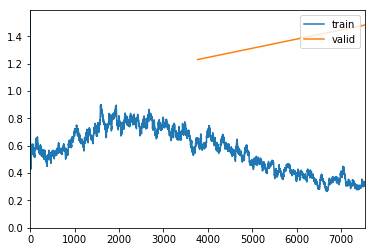

Better model found at epoch 0 with val_loss value: 1.2306005954742432.


In [36]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-1/(2.6**4),1e-1), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wikipt-30k-FT-virtual-operator-classifier-step2')])


In [ ]:
learn.load('wikipt-30k-FT-virtual-operator-classifier-step2')

epoch,train_loss,valid_loss,accuracy,time
0,0.477384,0.698441,0.903648,02:42
1,0.349925,0.317941,0.926169,02:44
2,0.223929,0.192863,0.954716,02:34
3,0.110455,0.151546,0.963206,02:29


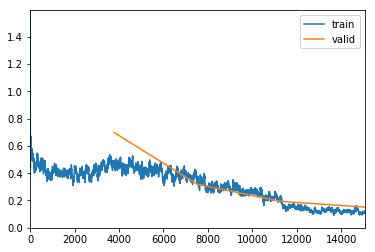

Better model found at epoch 0 with val_loss value: 0.6984413862228394.
Better model found at epoch 1 with val_loss value: 0.31794100999832153.
Better model found at epoch 2 with val_loss value: 0.1928633153438568.
Better model found at epoch 3 with val_loss value: 0.1515456885099411.


In [38]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wikipt-30k-FT-virtual-operator-classifier-step3')])


In [ ]:
learn.purge()

In [ ]:
learn.load('wikipt-30k-FT-virtual-operator-classifier-step3')

epoch,train_loss,valid_loss,accuracy,time
0,0.081569,0.156163,0.963411,03:31
1,0.077102,0.156989,0.964250,03:31
2,0.077238,0.156249,0.964661,03:29
3,0.064843,0.161280,0.964624,03:25


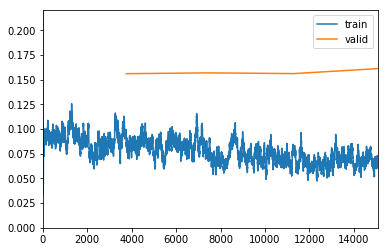

Better model found at epoch 0 with val_loss value: 0.1561630815267563.


In [40]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wikipt-30k-FT-virtual-operator-classifier-step4')])

In [ ]:
learn.load('wikipt-30k-FT-virtual-operator-classifier-step4')

In [53]:
y = []
for item in test_dataset.itertuples():
    label = item[2]
    label_id = learn.data.classes.index(label)
    y.append(label_id)

In [47]:
preds_test = learn.get_preds(ds_type = DatasetType.Test, ordered=True)

In [48]:
y_hat = torch.argmax(preds_test[0], dim=1)

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y, y_hat, target_names=learn.data.classes, digits=3))

                                                                  precision    recall  f1-score   support

                     Sintomas.Genérico.Atualização de endereço G      0.974     0.974     0.974        76
                          Sintomas.Genérico.Canal Globo não pega      0.737     0.773     0.754       304
                           Sintomas.Genérico.Canal HD não pega G      0.933     0.944     0.939       697
                     Sintomas.Genérico.Canal adulto não pega (G)      0.885     0.676     0.767        34
                      Sintomas.Genérico.Canal comum não pega (G)      0.886     0.839     0.862      1200
                                Sintomas.Genérico.Canal não pega      0.945     0.961     0.953      5967
                       Sintomas.Genérico.Canal opcional não pega      0.824     0.865     0.844       222
                                 Sintomas.Genérico.Canal travado      0.906     0.933     0.919       477
                                    Sintomas.